In [1]:
# https://arxiv.org/pdf/1903.07320.pdf

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import pymc3 as pm
import arviz as az 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def hifi_model(x):
    return (6*x - 2)**2 * np.sin(12*x-4)

In [5]:
def lofi_model(x):
    return 0.5*hifi_model(x) + 10*(x-0.5) + 5

In [6]:
x_true = np.linspace(0, 1, 100)[:,np.newaxis]

In [7]:
lofi_true = lofi_model(x_true)[:,0]
hifi_true = hifi_model(x_true)[:,0]

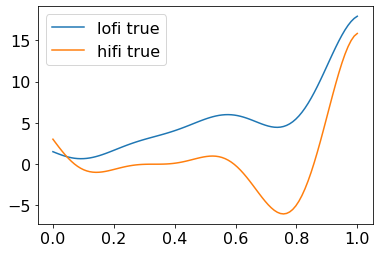

In [8]:
plt.figure()
plt.plot(x_true, lofi_true, label='lofi true')
plt.plot(x_true, hifi_true, label='hifi true')
plt.legend()

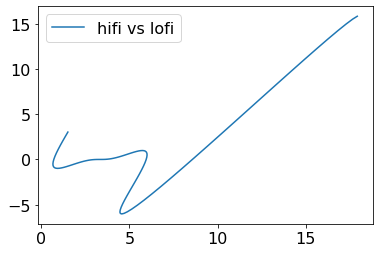

In [9]:
# Figure 6 in B.1: 1903.07320
plt.figure()
plt.plot(lofi_true, hifi_true, label='hifi vs lofi')
plt.legend()

# bridge functions

In [10]:
def bridge_additive(lofi, hifi):
    return hifi-lofi

In [11]:
def bridge_mult(lofi, hifi):
    return hifi/lofi

In [12]:
def mfm_additive(lofi, bridge):
    return lofi + bridge

In [13]:
def mfm_mult(lofi, bridge):
    return lofi * bridge

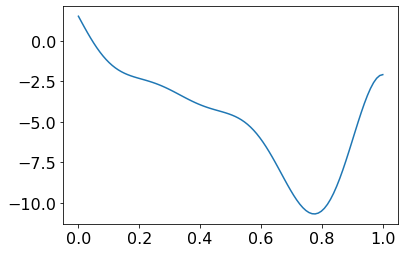

In [14]:
plt.figure()
plt.plot(x_true, bridge_additive(lofi_true, hifi_true))

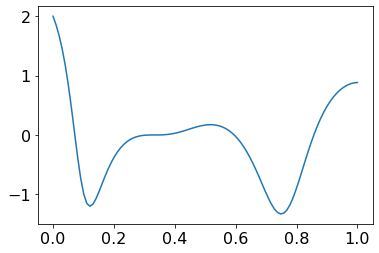

In [15]:
plt.figure()
plt.plot(x_true, bridge_mult(lofi_true, hifi_true))

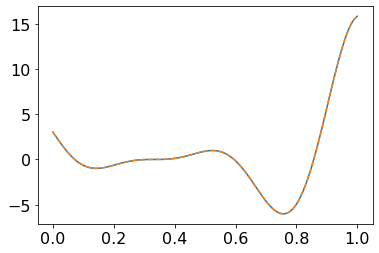

In [16]:
plt.figure()
plt.plot(x_true, hifi_true)
plt.plot(x_true, mfm_additive(lofi_true, bridge_additive(lofi_true, hifi_true)), ls='--')

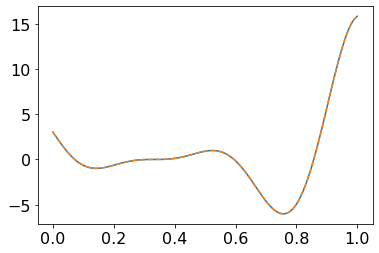

In [17]:
plt.figure()
plt.plot(x_true, hifi_true)
plt.plot(x_true, mfm_mult(lofi_true, bridge_mult(lofi_true, hifi_true)), ls='--')

# train and test data

In [18]:
# lofi_x = np.sort(np.random.uniform(size=(100, 1)), axis=0)
lofi_x = np.linspace(0, 1, 20)[:,np.newaxis]
train_lofi = lofi_model(lofi_x)[:,0]

In [19]:
train_x = np.sort(np.random.uniform(size=(8, 1)), axis=0)
# train_x = np.array([0.1, 0.2, 0.65, 0.7])[:,np.newaxis]
# test_x = np.sort(np.random.uniform(size=(20, 1)), axis=0)

In [20]:
train_hifi = hifi_model(train_x)[:,0]
# test_hifi = hifi_model(test_x)[:,0]

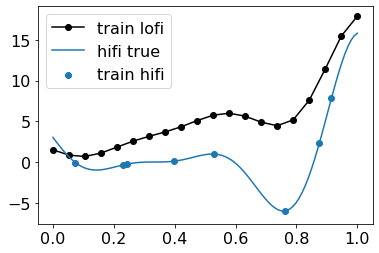

In [21]:
plt.figure()

plt.plot(lofi_x, train_lofi, 'k-o', label='train lofi')
plt.plot(x_true, hifi_true, label='hifi true')

plt.scatter(train_x, train_hifi, label='train hifi')
# plt.scatter(test_x, test_hifi, label='test hifi')

plt.legend()

# gpr fits

In [22]:
# help from this example https://docs.pymc.io/notebooks/GP-Marginal.html

In [23]:
def fit_gp(X, y, sample=False):
    with pm.Model() as model:
        ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
#         ℓ = pm.HalfCauchy("ℓ", beta=5)
        η = pm.HalfCauchy("η", beta=5)

        cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
#         cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ)
    
        gp = pm.gp.Marginal(cov_func=cov)

        σ = pm.HalfCauchy("σ", beta=5)
        y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

        mp = pm.find_MAP()
        
        
    if sample:
        with model:
#             step = pm.Metropolis()
#             step = pm.HamiltonianMC()
            step = pm.NUTS()
            trace = pm.sample(2000, cores=2, chains=2, step=step)
        
            az.plot_trace(trace);
        
    return model, gp, mp

In [24]:
def plot_gpr(X, y, gp, mp, sample=False):
    mu, var = gp.predict(X, point=mp, diag=False)
    
    X_new = np.linspace(0, 1, 100)[:,np.newaxis]
    
    if sample:
        mu_new, var_new = gp.predict(X_new, diag=False)
    else:
        mu_new, var_new = gp.predict(X_new, point=mp, diag=False)
    
    plt.figure()
    plt.plot(X, y,' go',markerfacecolor='none', label='data')
    plt.plot(X, mu, label='fit')
    
    plt.plot(X_new, mu_new, label='fit more points')
    
    plt.legend()

In [25]:
def fit_and_plot(X, y, sample=False):
    pm_model, gp, mp = fit_gp(X, y, sample)
    plot_gpr(X, y, gp, mp, sample)
    return gp, mp

In [26]:
# for multifidelity modelling we make GPR fits for lofi and the bridge function
# we will also make a GPR fit for the hifi training test to compare

In [40]:
# np.save("test-lofi.npy", np.stack((lofi_x[:,0], train_lofi)))

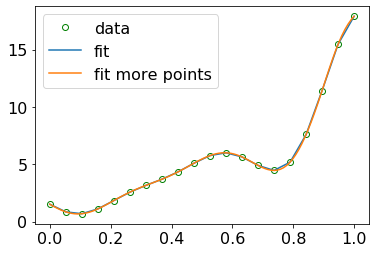

In [27]:
# GPR lofi
lofi_gp, lofi_mp = fit_and_plot(lofi_x, train_lofi)

In [28]:
# make brdige data
mu, _  = lofi_gp.predict(train_x, point=lofi_mp, diag=False)
train_brdige = bridge_additive(mu ,train_hifi)

In [39]:
# np.save("test-bridge.npy", np.stack((train_x[:,0], train_brdige)))

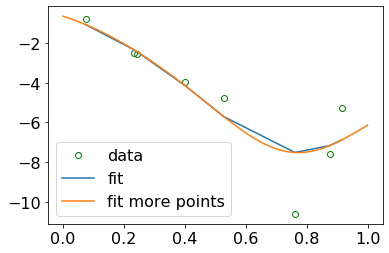

In [29]:
# GPR bridge
bridge_gp, bridge_mp = fit_and_plot(train_x, train_brdige)

In [38]:
# np.save("test-hifi.npy", np.stack((train_x[:,0], train_hifi)))

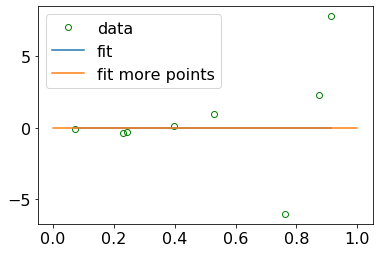

In [30]:
# GPR hifi so that we can compare
# this data has caused me trouble fitting
hifi_gp, hifi_mp = fit_and_plot(train_x, train_hifi, sample=False)

In [31]:
# multifidelity model: mfm
def mfm_predict(x, lofi_gp, lofi_mp, bridge_gp, bridge_mp, bridge_func):
    lofi_mu, lofi_var = lofi_gp.predict(x, point=lofi_mp, diag=True)
    bridge_mu, bridge_var = bridge_gp.predict(x, point=bridge_mp, diag=True)
    return lofi_mu, bridge_mu, bridge_func(lofi_mu, bridge_mu), bridge_func(lofi_var, bridge_var)

In [32]:
lofi_mu, bridge_mu, mfm, mfm_var = mfm_predict(x_true,
                                      lofi_gp,
                                      lofi_mp,
                                      bridge_gp,
                                      bridge_mp,
                                      bridge_func=mfm_additive)

In [33]:
gp_hifi_mu, gp_hifi_var = hifi_gp.predict(x_true, point=hifi_mp, diag=True)

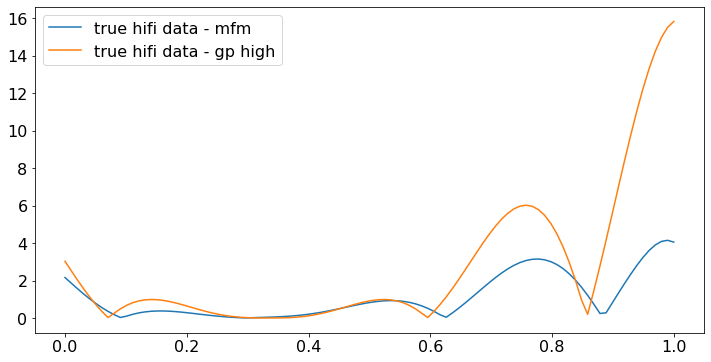

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(x_true, np.abs(hifi_true-mfm), label='true hifi data - mfm')
plt.plot(x_true, np.abs(hifi_true-(gp_hifi_mu)), label='true hifi data - gp high')
plt.legend()
# plt.yscale('log')

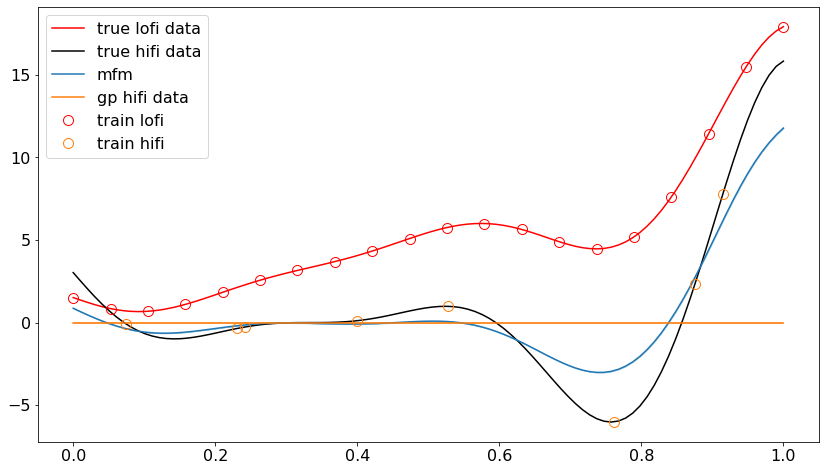

In [35]:
plt.figure(figsize=(14, 8))
plt.plot(x_true, lofi_true, label='true lofi data', c='r')
plt.plot(x_true, hifi_true, label='true hifi data', c='k')

plt.plot(x_true, mfm, label='mfm', c='C0')
plt.fill_between(x_true[:,0],
                 (mfm - 2*np.sqrt(gp_hifi_var)),
                 (mfm + 2*np.sqrt(gp_hifi_var)),
                 alpha=0.3, color='C0')

plt.plot(x_true, gp_hifi_mu, label='gp hifi data', c='C1')
plt.fill_between(x_true[:,0],
                 (gp_hifi_mu - 2*np.sqrt(gp_hifi_var)),
                 (gp_hifi_mu + 2*np.sqrt(gp_hifi_var)),
                 alpha=0.3, color='C1')


plt.plot(lofi_x, train_lofi, 'ro', label='train lofi', markerfacecolor='none', markersize=10)
plt.plot(train_x, train_hifi, 'o', c='C1', label='train hifi', markerfacecolor='none', markersize=10)


plt.legend()

In [36]:
# we find that the multifidelity model outperforms the GPR model that was trained only on the hifi data.